## Author: Shilpaj Bhalerao

From one of the very good submissions this week!

In [1]:
%pip install --pre torch==2.0.1+cu118 torchvision==0.15.2+cu118 --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118
  Using cached https://download.pytorch.org/whl/cu118/torchvision-0.15.2%2Bcu118-cp39-cp39-win_amd64.whl (4.9 MB)
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.15.2
    Uninstalling torchvision-0.15.2:
      Successfully uninstalled torchvision-0.15.2
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch, torchvision

torch.__version__, torchvision.__version__

('2.0.1+cu118', '0.15.2+cu118')

In [3]:
import torch
torch.cuda.is_available()

True

In [4]:
# Install Albumentation library
%pip install albumentations

Note: you may need to restart the kernel to use updated packages.


In [5]:
# Install LR finder
%pip install torch-lr-finder

Note: you may need to restart the kernel to use updated packages.


In [6]:
# Install GradCam
%pip install grad-cam

Note: you may need to restart the kernel to use updated packages.


In [7]:
# Import all the required modules
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import math
from collections import OrderedDict
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms


import albumentations as A
from albumentations.pytorch import ToTensorV2


from torch_lr_finder import LRFinder

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image


i:\TSAI\2023\ERA\S11\.venv\lib\site-packages\torch_lr_finder\lr_finder.py:5: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [8]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())
test = datasets.CIFAR10('./data', train=False, download=True, transform=transforms.ToTensor())

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [9]:
%pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


[Train]
 - Total Train Images: 50000
 - Tensor Shape: (3, 32, 32)
 - min: (0.0, 0.0, 0.0)
 - max: (1.0, 1.0, 1.0)
 - mean: (0.49139968, 0.48215827, 0.44653124)
 - std: (0.24703233, 0.24348505, 0.26158768)
 - var: (0.061024975, 0.05928497, 0.06842812)
[Test]
 - Total Test Images: 10000
 - Tensor Shape: (3, 32, 32)
 - min: (0.0, 0.0, 0.0)
 - max: (1.0, 1.0, 1.0)
 - mean: (0.49421427, 0.48513183, 0.45040932)
 - std: (0.24665256, 0.24289224, 0.26159248)
 - var: (0.06083748, 0.058996636, 0.06843062)


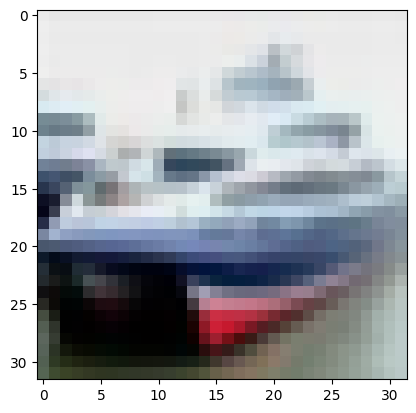

In [10]:
from utils import get_cifar_statistics

get_cifar_statistics(train)
get_cifar_statistics(test, data_set_type="Test")

In [11]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


i:\TSAI\2023\ERA\S11\visualize.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


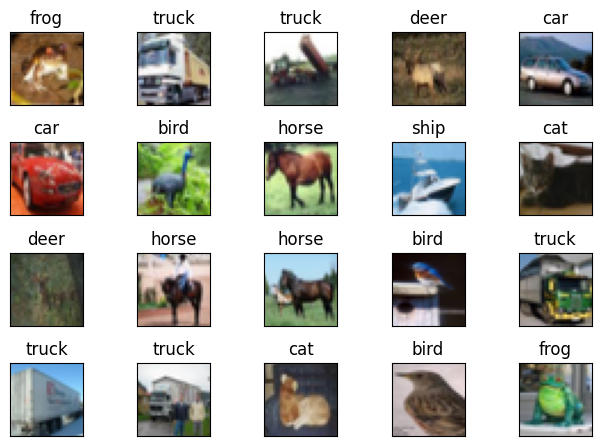

In [12]:
from visualize import display_cifar_data_samples

DISPLAY_SAMPLES = 20
sample, _ = train[4]
display_cifar_data_samples(train, DISPLAY_SAMPLES, classes)

In [13]:
from datasets import AlbumDataset
from augmentations import train_set_transforms, test_set_transforms

# Get the dictionary with augmentations
train_transforms = A.Compose(train_set_transforms.values())
test_transforms = A.Compose(test_set_transforms.values())

# Create custom Dataset to support albumentations library
train_set = AlbumDataset('./data', train=True, download=True, transform=train_transforms)
test_set = AlbumDataset('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


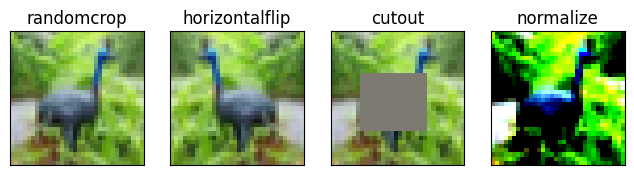

In [14]:
from visualize import visualize_cifar_augmentation

aug_train = AlbumDataset('./data', train=True, download=True)

aug_set_transforms = {
    'randomcrop': A.RandomCrop(height=32, width=32, p=1),
    'horizontalflip': A.HorizontalFlip(p=1),
    'cutout': A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=1, min_width=1, fill_value=(0.49139968*255, 0.48215827*255, 0.44653124*255), mask_fill_value=None, p=1),
    'normalize': A.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233, 0.24348505, 0.26158768)),
    'standardize': ToTensorV2(),
}

visualize_cifar_augmentation(aug_train, aug_set_transforms)

In [15]:
SEED = 8
BATCH_SIZE = 512

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=BATCH_SIZE, num_workers=0, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_set, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_set, **dataloader_args)

CUDA Available? True


In [21]:
from resnet import ResNet18
from utils import get_summary

get_summary(ResNet18(), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [22]:
# Put the model on selected device
model = ResNet18().to(device)

# Optimization algorithm to update the weights
LEARNING_RATE = 0.03
WEIGHT_DECAY = 1e-4
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=WEIGHT_DECAY)

# Loss Function
criterion = nn.CrossEntropyLoss()

  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 6.79E-02


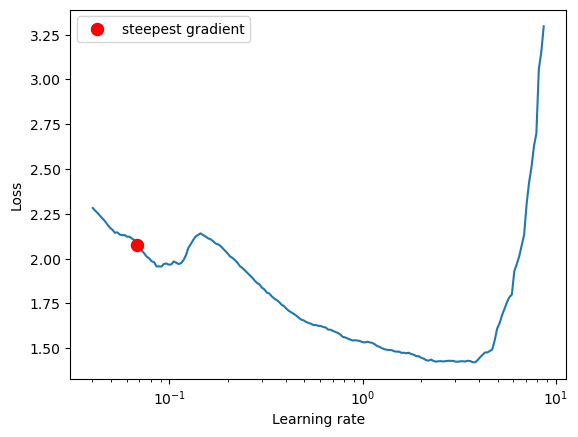

In [17]:
# LR finder
from torch_lr_finder import LRFinder
lr_finder2 = LRFinder(model, optimizer, criterion, device='cuda')
lr_finder2.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder2.plot()
lr_finder2.reset()

In [18]:
EPOCHS = 20

MAX_LR = 6.79E-02    # Suggested LR
STEPS_PER_EPOCH = len(train_loader)

In [17]:
from training_utils import train, test, get_lr

In [20]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []
learning_rates = []
test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

# Scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                max_lr=MAX_LR,
                                                steps_per_epoch=STEPS_PER_EPOCH,
                                                epochs=EPOCHS,
                                                pct_start=int(0.3*EPOCHS)/EPOCHS if EPOCHS != 1 else 0.5,   # 30% of total number of Epochs
                                                div_factor=100,
                                                three_phase=False,
                                                final_div_factor=100,
                                                anneal_strategy="linear"
                                                )

# For each epoch
for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}')

    # Train the model on training dataset and append the training loss and accuracy
    correct, processed, train_loss = train(model, device, train_loader, optimizer, criterion, scheduler)
    train_acc.append(100 * correct / processed)
    train_losses.append(train_loss / len(train_loader))
    learning_rates.append(get_lr(optimizer))

    # Test the model's performance on test dataset and append the training loss and accuracy
    correct, test_loss = test(model, device, test_loader, criterion)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

Epoch 1


Train: Loss=1.3552 Batch_id=97 Accuracy=37.66: 100%|██████████| 98/98 [00:19<00:00,  5.15it/s]


Test set: Average loss: 0.0030, Accuracy: 4707/10000 (47.07%)

Epoch 2


Train: Loss=0.9453 Batch_id=97 Accuracy=60.56: 100%|██████████| 98/98 [00:19<00:00,  5.16it/s]


Test set: Average loss: 0.0028, Accuracy: 5467/10000 (54.67%)

Epoch 3


Train: Loss=0.7217 Batch_id=97 Accuracy=71.21: 100%|██████████| 98/98 [00:19<00:00,  4.92it/s]


Test set: Average loss: 0.0018, Accuracy: 6940/10000 (69.40%)

Epoch 4


Train: Loss=0.6053 Batch_id=97 Accuracy=77.48: 100%|██████████| 98/98 [00:19<00:00,  5.00it/s]


Test set: Average loss: 0.0014, Accuracy: 7571/10000 (75.71%)

Epoch 5


Train: Loss=0.5059 Batch_id=97 Accuracy=80.69: 100%|██████████| 98/98 [00:19<00:00,  5.09it/s]


Test set: Average loss: 0.0017, Accuracy: 7232/10000 (72.32%)

Epoch 6


Train: Loss=0.4920 Batch_id=97 Accuracy=83.48: 100%|██████████| 98/98 [00:18<00:00,  5.17it/s]


Test set: Average loss: 0.0012, Accuracy: 8026/10000 (80.26%)

Epoch 7


Train: Loss=0.4215 Batch_id=97 Accuracy=85.32: 100%|██████████| 98/98 [00:18<00:00,  5.17it/s]


Test set: Average loss: 0.0020, Accuracy: 7132/10000 (71.32%)

Epoch 8


Train: Loss=0.3810 Batch_id=97 Accuracy=87.61: 100%|██████████| 98/98 [00:19<00:00,  5.05it/s]


Test set: Average loss: 0.0014, Accuracy: 7967/10000 (79.67%)

Epoch 9


Train: Loss=0.2669 Batch_id=97 Accuracy=89.86: 100%|██████████| 98/98 [00:19<00:00,  5.15it/s]


Test set: Average loss: 0.0014, Accuracy: 7969/10000 (79.69%)

Epoch 10


Train: Loss=0.2618 Batch_id=97 Accuracy=91.54: 100%|██████████| 98/98 [00:18<00:00,  5.20it/s]


Test set: Average loss: 0.0014, Accuracy: 8022/10000 (80.22%)

Epoch 11


Train: Loss=0.1927 Batch_id=97 Accuracy=92.33: 100%|██████████| 98/98 [00:18<00:00,  5.18it/s]


Test set: Average loss: 0.0012, Accuracy: 8227/10000 (82.27%)

Epoch 12


Train: Loss=0.2309 Batch_id=97 Accuracy=94.08: 100%|██████████| 98/98 [00:19<00:00,  5.12it/s]


Test set: Average loss: 0.0013, Accuracy: 8298/10000 (82.98%)

Epoch 13


Train: Loss=0.1270 Batch_id=97 Accuracy=94.88: 100%|██████████| 98/98 [00:18<00:00,  5.17it/s]


Test set: Average loss: 0.0012, Accuracy: 8312/10000 (83.12%)

Epoch 14


Train: Loss=0.1091 Batch_id=97 Accuracy=95.72: 100%|██████████| 98/98 [00:19<00:00,  5.11it/s]


Test set: Average loss: 0.0015, Accuracy: 8033/10000 (80.33%)

Epoch 15


Train: Loss=0.0989 Batch_id=97 Accuracy=96.56: 100%|██████████| 98/98 [00:19<00:00,  5.12it/s]


Test set: Average loss: 0.0011, Accuracy: 8493/10000 (84.93%)

Epoch 16


Train: Loss=0.1195 Batch_id=97 Accuracy=97.48: 100%|██████████| 98/98 [00:19<00:00,  5.15it/s]


Test set: Average loss: 0.0012, Accuracy: 8445/10000 (84.45%)

Epoch 17


Train: Loss=0.0582 Batch_id=97 Accuracy=98.06: 100%|██████████| 98/98 [00:18<00:00,  5.20it/s]


Test set: Average loss: 0.0010, Accuracy: 8751/10000 (87.51%)

Epoch 18


Train: Loss=0.0329 Batch_id=97 Accuracy=98.58: 100%|██████████| 98/98 [00:18<00:00,  5.17it/s]


Test set: Average loss: 0.0010, Accuracy: 8789/10000 (87.89%)

Epoch 19


Train: Loss=0.0411 Batch_id=97 Accuracy=99.05: 100%|██████████| 98/98 [00:18<00:00,  5.19it/s]


Test set: Average loss: 0.0009, Accuracy: 8873/10000 (88.73%)

Epoch 20


Train: Loss=0.0087 Batch_id=97 Accuracy=99.24: 100%|██████████| 98/98 [00:19<00:00,  5.11it/s]


Test set: Average loss: 0.0009, Accuracy: 8895/10000 (88.95%)



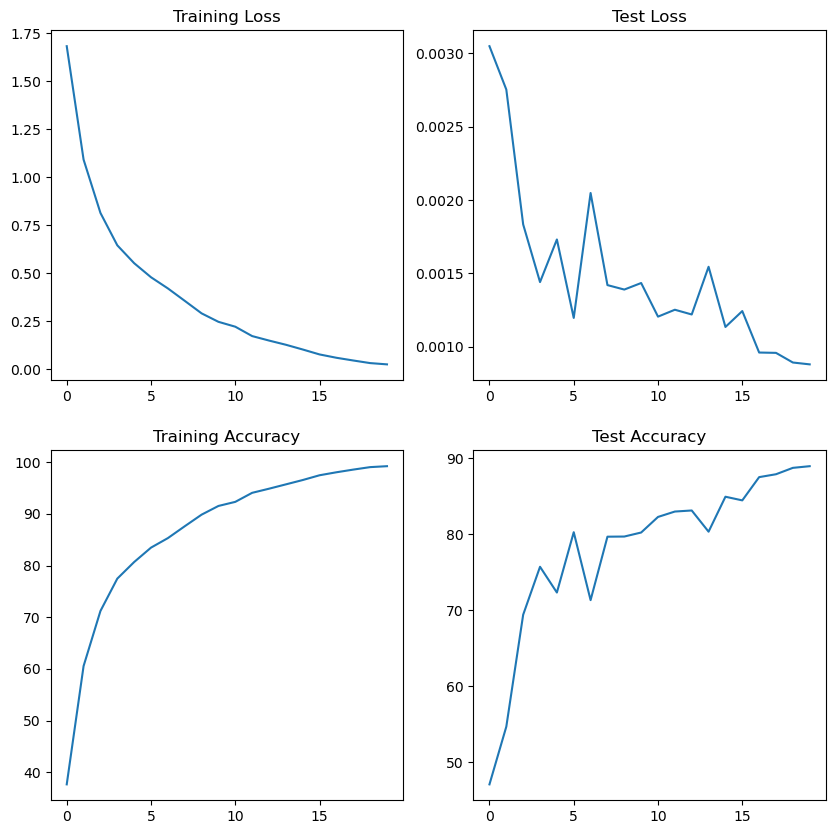

In [21]:
# Print loss and accuracy
from visualize import display_loss_and_accuracies

display_loss_and_accuracies(train_losses, train_acc, test_losses, test_acc)

Text(0.5, 1.0, 'Training Learning Rate')

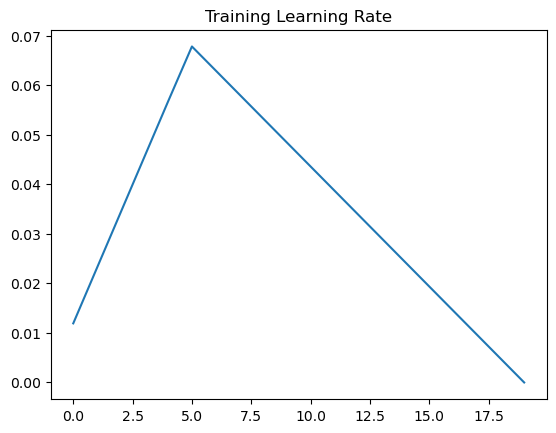

In [22]:
import matplotlib.pyplot as plt

plt.plot(learning_rates)
plt.title("Training Learning Rate")

In [18]:
torch.cuda.is_available()

True

In [23]:
# torch.save(model.state_dict(), "model.pth")
model.load_state_dict(torch.load("model.pth"), strict=False)

<All keys matched successfully>

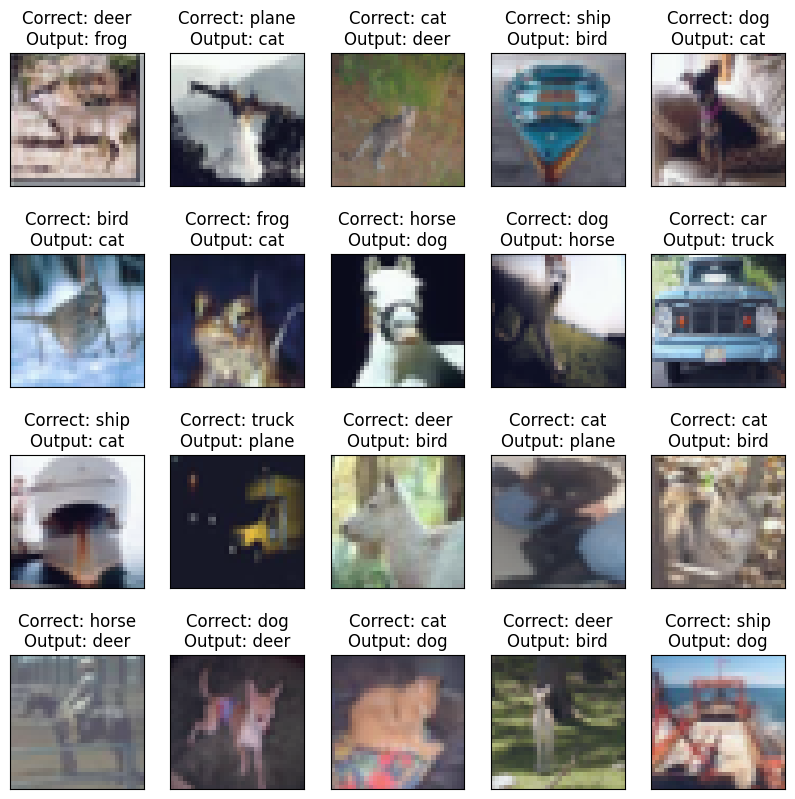

In [24]:
from utils import get_misclassified_data
from visualize import display_cifar_misclassified_data

# Denormalize the data using test mean and std deviation
inv_normalize = transforms.Normalize(
    mean=[-0.50/0.23, -0.50/0.23, -0.50/0.23],
    std=[1/0.23, 1/0.23, 1/0.23]
)

# Get the misclassified data from test dataset
misclassified_data = get_misclassified_data(model, device, test_loader)

# Plot the misclassified data
display_cifar_misclassified_data(misclassified_data, classes, inv_normalize, number_of_samples=20)

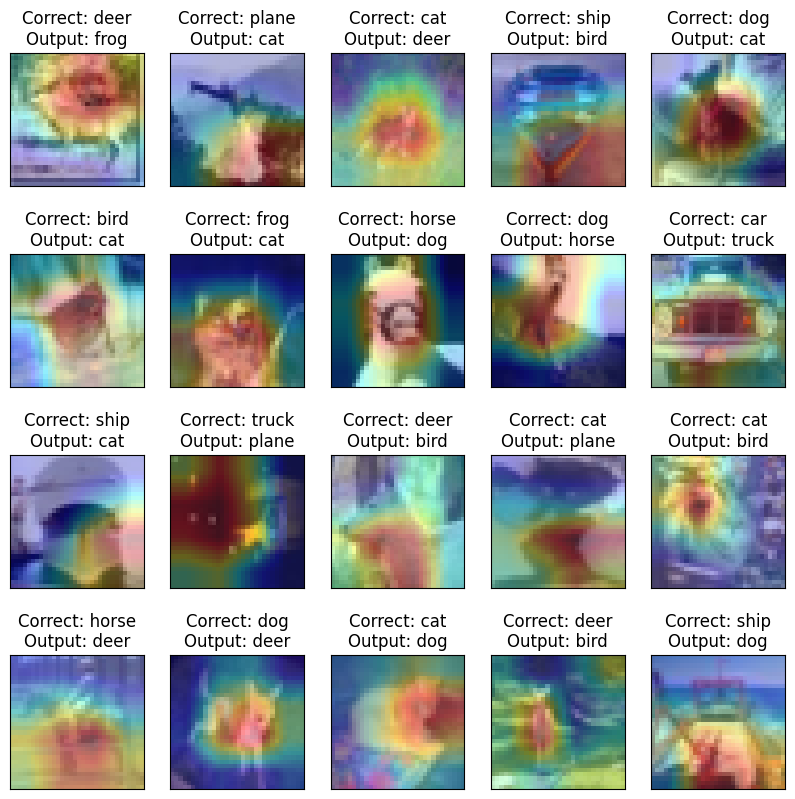

In [25]:
from utils import display_gradcam_output

target_layers = [model.layer4[-1]]
# targets = [ClassifierOutputTarget(7)]
targets = None

display_gradcam_output(misclassified_data, classes, inv_normalize, model, target_layers, targets, number_of_samples=20, transparency=0.70)

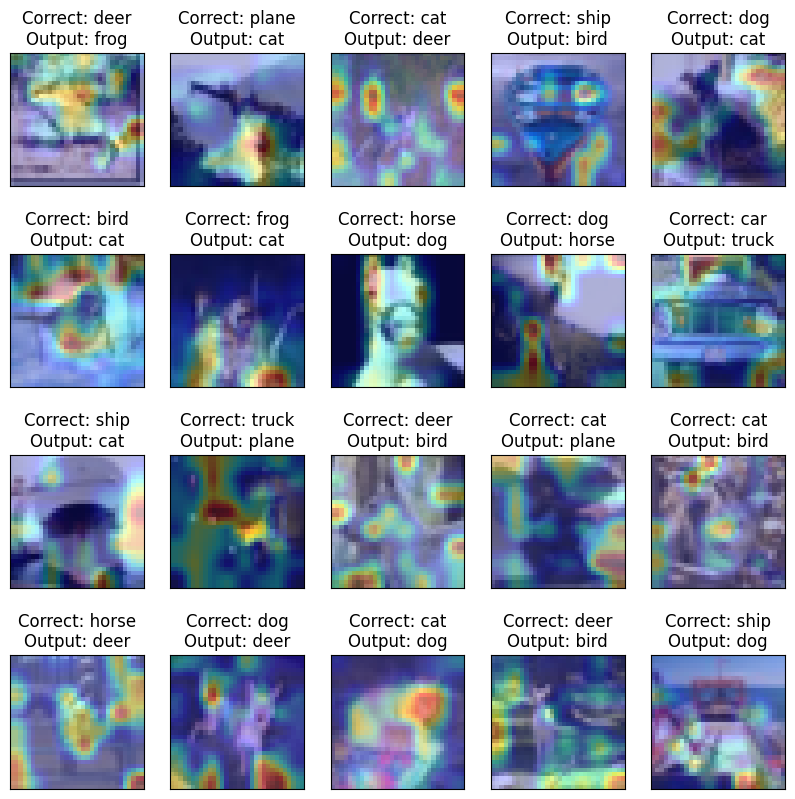

In [26]:
target_layers = [model.layer3[-2]]
display_gradcam_output(misclassified_data, classes, inv_normalize, model, target_layers, targets, number_of_samples=20, transparency=0.70)

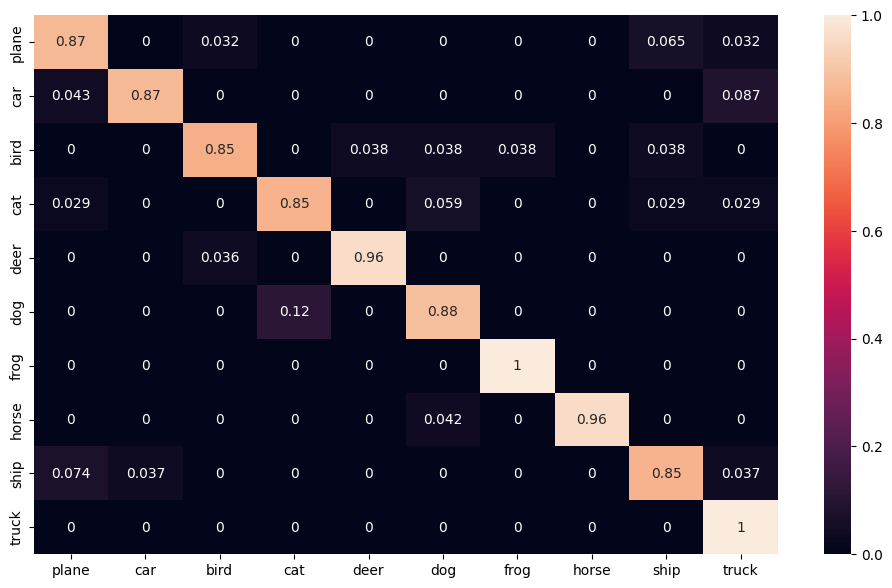

In [27]:
from visualize import visualize_confusion_matrix

visualize_confusion_matrix(classes, device, model, test_loader)

In [75]:
import gradio as gr

def hello(input1, input2, input3):
    return f'{input1} + {input2} Rohan'

demo = gr.Interface(hello, ["text", gr.Slider(0, 5, step=1), gr.Image(shape=(32, 32))], "text")
demo.launch()

Running on local URL:  http://127.0.0.1:7886

To create a public link, set `share=True` in `launch()`.


Traceback (most recent call last):
  File "i:\TSAI\2023\ERA\S11\.venv\lib\site-packages\gradio\routes.py", line 442, in run_predict
    output = await app.get_blocks().process_api(
  File "i:\TSAI\2023\ERA\S11\.venv\lib\site-packages\gradio\blocks.py", line 1392, in process_api
    result = await self.call_function(
  File "i:\TSAI\2023\ERA\S11\.venv\lib\site-packages\gradio\blocks.py", line 1097, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "i:\TSAI\2023\ERA\S11\.venv\lib\site-packages\anyio\to_thread.py", line 33, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "i:\TSAI\2023\ERA\S11\.venv\lib\site-packages\anyio\_backends\_asyncio.py", line 877, in run_sync_in_worker_thread
    return await future
  File "i:\TSAI\2023\ERA\S11\.venv\lib\site-packages\anyio\_backends\_asyncio.py", line 807, in run
    result = context.run(func, *args)
  File "i:\TSAI\2023\ERA\S11\.venv\lib\site-packages\gradio\utils.py", line 703, in wrapper
   

In [68]:
import numpy as np
import gradio as gr
from PIL import Image
from pytorch_grad_cam import GradCAM

def inference(input_img, transparency):
    transform = transforms.ToTensor()
    input_img = transform(input_img)
    input_img = input_img.to(device)
    input_img = input_img.unsqueeze(0)
    outputs = model(input_img)
    _, prediction = torch.max(outputs, 1)
    target_layers = [model.layer2[-2]]
    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
    grayscale_cam = cam(input_tensor=input_img, targets=targets)
    grayscale_cam = grayscale_cam[0, :]
    img = input_img.squeeze(0).to('cpu')
    img = inv_normalize(img)
    rgb_img = np.transpose(img, (1, 2, 0))
    rgb_img = rgb_img.numpy()
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True, image_weight=transparency)
    return classes[prediction[0].item()], visualization

demo = gr.Interface(inference, [gr.Image(shape=(32, 32)), gr.Slider(0, 1)], ["text", gr.Image(shape=(32, 32)).style(width=128, height=128)])
demo.launch()

C:\Users\Rohan\AppData\Local\Temp\ipykernel_26312\3304697879.py:25: GradioDeprecationWarning: The `style` method is deprecated. Please set these arguments in the constructor instead.
  demo = gr.Interface(inference, [gr.Image(shape=(32, 32)), gr.Slider(0, 1)], ["text", gr.Image(shape=(32, 32)).style(width=128, height=128)])


Running on local URL:  http://127.0.0.1:7881

To create a public link, set `share=True` in `launch()`.


Traceback (most recent call last):
  File "i:\TSAI\2023\ERA\S11\.venv\lib\site-packages\gradio\routes.py", line 442, in run_predict
    output = await app.get_blocks().process_api(
  File "i:\TSAI\2023\ERA\S11\.venv\lib\site-packages\gradio\blocks.py", line 1392, in process_api
    result = await self.call_function(
  File "i:\TSAI\2023\ERA\S11\.venv\lib\site-packages\gradio\blocks.py", line 1097, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "i:\TSAI\2023\ERA\S11\.venv\lib\site-packages\anyio\to_thread.py", line 33, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "i:\TSAI\2023\ERA\S11\.venv\lib\site-packages\anyio\_backends\_asyncio.py", line 877, in run_sync_in_worker_thread
    return await future
  File "i:\TSAI\2023\ERA\S11\.venv\lib\site-packages\anyio\_backends\_asyncio.py", line 807, in run
    result = context.run(func, *args)
  File "i:\TSAI\2023\ERA\S11\.venv\lib\site-packages\gradio\utils.py", line 703, in wrapper
   